In [1]:
! nvidia-smi

Sun Dec  4 20:01:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   28C    P8    11W / 120W |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import shutil
import torch.nn as nn 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import sklearn
from sklearn.metrics import f1_score   
import math
import warnings

from torch.nn.modules.utils import _pair, _reverse_repeat_tuple
from torch.nn.common_types import _size_2_t, _size_any_t
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch._torch_docs import reproducibility_notes
from torch.nn import Module
import os


from typing import Optional, List, Tuple, Union

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import argparse
import torch.optim as optim
import time
from tqdm.auto import tqdm

In [3]:
#!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=77d7ab1ed111ea28cebafc310fb34c4e2f2c8072f59b3dbd7ed5a0b1fb6af4c3
  Stored in directory: /root/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [3]:
"""
! mkdir ~/.kaggle
! cp /notebooks/kaggle.json ~/.kaggle/  
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip /notebooks/stanford-cars-dataset.zip
"""

/bin/bash: kaggle: command not found
Archive:  /notebooks/stanford-cars-dataset.zip
replace cars_annos.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [29]:
#!unzip /notebooks/stanford-cars-dataset.zip

Archive:  /notebooks/stanford-cars-dataset.zip
replace cars_annos.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
import pandas as pd
import scipy.io
mat = scipy.io.loadmat('/notebooks/Копия cars_meta.mat')
mat = dict(class_names=mat['class_names'][0])
cars_df = pd.DataFrame(mat)
cars_df.to_csv("/notebooks/names.csv")

mat = scipy.io.loadmat('/notebooks/Копия cars_train_annos.mat')
print(len(mat['annotations'][0]))
class_df = dict(label=[], names=[])
for c in mat['annotations'][0]:
  cl = c[4][0][0] - 1
  n = c[5][0]
  class_df['label'].append(cl)
  class_df['names'].append(n)
class_df=pd.DataFrame(class_df, dtype=np.int32)
class_df.to_csv("/notebooks/anno_train.csv")

mat = scipy.io.loadmat('/notebooks/cars_test_annos_withlabels.mat')
print(len(mat['annotations'][0]))
class_df1 = dict(label=[], names=[])
for c in mat['annotations'][0]:
  cl = c[4][0][0] - 1
  n = c[5][0]
  class_df1['label'].append(cl)
  class_df1['names'].append(n)
class_df1=pd.DataFrame(class_df1, dtype=np.int32)
class_df1.to_csv("/notebooks/anno_test.csv")

8144


/tmp/ipykernel_32/1952084630.py:16: FutureWarning: Could not cast to int32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  class_df=pd.DataFrame(class_df, dtype=np.int32)


8041


/tmp/ipykernel_32/1952084630.py:27: FutureWarning: Could not cast to int32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  class_df1=pd.DataFrame(class_df1, dtype=np.int32)


In [5]:
def create_dirs():
  for l in cars_df['class_names']:

    name_dir = l[0]
    if '/' in l[0]:
      name_dir = l[0].replace('/', '')
    
    try:
      os.mkdir(f'/notebooks/cars_train/cars_train/{name_dir}')

    except FileExistsError as F:
      continue

  for l in cars_df['class_names']:

    name_dir = l[0]
    if '/' in l[0]:
      name_dir = l[0].replace('/', '')
    
    try:
      os.mkdir(f'/notebooks/cars_test/cars_test/{name_dir}')

    except FileExistsError as F:
      continue
    
def create_classes(start=0, end=8144):

  train_path = '/notebooks/cars_train/cars_train/'
  test_path = '/notebooks/cars_test/cars_test/'

  for l, img in zip(class_df['label'][start:end], class_df['names'][start:end]):

    name_dir = cars_df['class_names'][l][0]
    if '/' in name_dir:
      name_dir = name_dir.replace('/', '')
    name_dir += '/'

    shutil.move(train_path+img, train_path+name_dir+img)

  for l, img in zip(class_df1['label'][start:end], class_df1['names'][start:end]):

    name_dir = cars_df['class_names'][l][0]
    if '/' in name_dir:
      name_dir = name_dir.replace('/', '')
    name_dir += '/'

    shutil.move(test_path+img, test_path+name_dir+img)
    
def DELETE():
  shutil.rmtree('/notebooks/cars_train')
  shutil.rmtree('/notebooks/cars_test')
    
    
def create_sufficiant_dirs():
    root = '/notebooks/cars_train/cars_train'
    folders = list(os.walk(root))[1:]

    for folder in folders:
        # folder example: ('FOLDER/3', [], ['file'])
        if not folder[2]:
            os.rmdir(folder[0])

    root = '/notebooks/cars_test/cars_test'
    folders = list(os.walk(root))[1:]

    for folder in folders:
        # folder example: ('FOLDER/3', [], ['file'])
        if not folder[2]:
            os.rmdir(folder[0])
    


In [6]:
"""
DELETE()
!unzip /notebooks/stanford-cars-dataset.zip
create_dirs()
create_classes(start=0, end=8144

create_dirs()
create_classes(start=0, end=8144)
"""

FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/cars_train/cars_train/00001.jpg'

In [6]:
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

In [7]:
class _ConvNd(Module):

        __constants__ = ['stride', 'padding', 'dilation', 'groups',
                        'padding_mode', 'output_padding', 'in_channels',
                        'out_channels', 'kernel_size']
        __annotations__ = {'bias': Optional[torch.Tensor]}

        def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
            ...

        in_channels: int
        _reversed_padding_repeated_twice: List[int]
        out_channels: int
        kernel_size: Tuple[int, ...]
        stride: Tuple[int, ...]
        padding: Union[str, Tuple[int, ...]]
        dilation: Tuple[int, ...]
        transposed: bool
        output_padding: Tuple[int, ...]
        groups: int
        padding_mode: str
        weight: Tensor
        bias: Optional[Tensor]
        def __init__(self,in_channels: int, out_channels: int, kernel_size: Tuple[int, ...],stride: Tuple[int, ...], padding: Tuple[int, ...],
                     dilation: Tuple[int, ...], transposed: bool, output_padding: Tuple[int, ...],groups: int, bias: bool, padding_mode: str,
                     device=None, dtype=None) -> None:
            factory_kwargs = {'device': device, 'dtype': dtype}
            super(_ConvNd, self).__init__()
            if groups <= 0:
                raise ValueError('groups must be a positive integer')
            if in_channels % groups != 0:
                raise ValueError('in_channels must be divisible by groups')
            if out_channels % groups != 0:
                raise ValueError('out_channels must be divisible by groups')
            valid_padding_strings = {'same', 'valid'}
            if isinstance(padding, str):
                if padding not in valid_padding_strings:
                    raise ValueError(
                        "Invalid padding string {!r}, should be one of {}".format(
                            padding, valid_padding_strings))
                if padding == 'same' and any(s != 1 for s in stride):
                    raise ValueError("padding='same' is not supported for strided convolutions")

            valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
            if padding_mode not in valid_padding_modes:
                raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                    valid_padding_modes, padding_mode))
            self.in_channels = in_channels
            self.out_channels = out_channels
            self.kernel_size = kernel_size
            self.stride = stride
            self.padding = padding
            self.dilation = dilation
            self.transposed = transposed
            self.output_padding = output_padding
            self.groups = groups
            self.padding_mode = padding_mode
            # `_reversed_padding_repeated_twice` is the padding to be passed to
            # `F.pad` if needed (e.g., for non-zero padding types that are
            # implemented as two ops: padding + conv). `F.pad` accepts paddings in
            # reverse order than the dimension.
            if isinstance(self.padding, str):
                self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
                if padding == 'same':
                    for d, k, i in zip(dilation, kernel_size,
                                      range(len(kernel_size) - 1, -1, -1)):
                        total_padding = d * (k - 1)
                        left_pad = total_padding // 2
                        self._reversed_padding_repeated_twice[2 * i] = left_pad
                        self._reversed_padding_repeated_twice[2 * i + 1] = (
                            total_padding - left_pad)
            else:
                self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

            if transposed:
                self.weight = Parameter(torch.empty(
                    (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
            else:
                self.weight = Parameter(torch.empty(
                    (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
            if bias:
                self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
            else:
                self.register_parameter('bias', None)
            self.reset_parameters()

        def reset_parameters(self) -> None:
            # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
            # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
            # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
            init.kaiming_uniform_(self.weight, a=math.sqrt(5))
            if self.bias is not None:
                fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
                if fan_in != 0:
                    bound = 1 / math.sqrt(fan_in)
                    init.uniform_(self.bias, -bound, bound)

        def extra_repr(self):
            s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
                ', stride={stride}')
            if self.padding != (0,) * len(self.padding):
                s += ', padding={padding}'
            if self.dilation != (1,) * len(self.dilation):
                s += ', dilation={dilation}'
            if self.output_padding != (0,) * len(self.output_padding):
                s += ', output_padding={output_padding}'
            if self.groups != 1:
                s += ', groups={groups}'
            if self.bias is None:
                s += ', bias=False'
            if self.padding_mode != 'zeros':
                s += ', padding_mode={padding_mode}'
            return s.format(**self.__dict__)

        def __setstate__(self, state):
            super(_ConvNd, self).__setstate__(state)
            if not hasattr(self, 'padding_mode'):
                self.padding_mode = 'zeros'

In [8]:
class Conv2d(_ConvNd):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: Union[str, _size_2_t] = 0,
                 dilation: _size_2_t = 1, groups: int = 1, bias: bool = True,padding_mode: str = 'zeros', device=None,dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
                                     False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                                weight, bias, self.stride,
                                _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                            self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)

In [9]:
m = Conv2d(3, 32, 3, stride=1)
# non-square kernels and unequal stride and with padding

input = torch.randn(2, 3, 32, 32)
output = m(input)
print(output.shape)

torch.Size([2, 32, 30, 30])


In [10]:
class Linear(Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [11]:
m = Linear(20, 30)
input = torch.randn(128, 20)
output = m.forward(input)
print(output.size())

torch.Size([128, 30])


In [12]:
class _Loss(Module):
    reduction: str

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class _WeightedLoss(_Loss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_WeightedLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.weight: Optional[Tensor]

class CrossEntropyLoss(_WeightedLoss):
    __constants__ = ['ignore_index', 'reduction', 'label_smoothing']
    ignore_index: int
    label_smoothing: float

    def __init__(self, weight: Optional[Tensor] = None, size_average=None, ignore_index: int = -100,
                 reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None:
        super(CrossEntropyLoss, self).__init__(weight, size_average, reduce, reduction)
        self.ignore_index = ignore_index
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return F.cross_entropy(input, target, weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction,
                               label_smoothing=self.label_smoothing)


In [13]:
class _MaxPoolNd(Module):
    __constants__ = ['kernel_size', 'stride', 'padding', 'dilation',
                     'return_indices', 'ceil_mode']
    return_indices: bool
    ceil_mode: bool

    def __init__(self, kernel_size: _size_any_t, stride: Optional[_size_any_t] = None,
                 padding: _size_any_t = 0, dilation: _size_any_t = 1,
                 return_indices: bool = False, ceil_mode: bool = False) -> None:
        super(_MaxPoolNd, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if (stride is not None) else kernel_size
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def extra_repr(self) -> str:
        return 'kernel_size={kernel_size}, stride={stride}, padding={padding}' \
            ', dilation={dilation}, ceil_mode={ceil_mode}'.format(**self.__dict__)

class MaxPool2d(_MaxPoolNd):
    kernel_size: _size_2_t
    stride: _size_2_t
    padding: _size_2_t
    dilation: _size_2_t

    def forward(self, input: Tensor):
        return F.max_pool2d(input, self.kernel_size, self.stride,
                            self.padding, self.dilation, ceil_mode=self.ceil_mode,
                            return_indices=self.return_indices)

In [14]:
class ReLU(Module):
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super(ReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input: Tensor) -> Tensor:
        return F.relu(input, inplace=self.inplace)

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [15]:
class VGG16(Module):

    def __init__(self, num_classes=10, shrink=7):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer2 = nn.Sequential(
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(), 
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU())
        self.layer4 = nn.Sequential(
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer5 = nn.Sequential(
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer6 = nn.Sequential(
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer7 = nn.Sequential(
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer9 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer10 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer12 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU())
        
        self.layer13 = nn.Sequential(
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            Linear(shrink*shrink*512, 4096),
            ReLU())
        
        self.fc1 = nn.Sequential(
            Linear(4096, 4096),
            ReLU())
        
        self.fc2= nn.Sequential(
            Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1.forward(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
 #       out = F.softmax(out)
        return out

In [16]:
model = VGG16(num_classes=3,shrink=7)
x = torch.randn(2, 3, 224, 224)
print(x.shape)
out = model(x)
print(out.shape)

torch.Size([2, 3, 224, 224])
torch.Size([2, 3])


In [17]:
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
def save_model(epochs, model, optimizer, criterion, dir):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"{dir}/model.pth")
def save_plots(train_acc, valid_acc, train_loss, valid_loss, f1, dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{dir}/accuracy.png")
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{dir}/loss.png")

    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        f1, color='red', linestyle='-', 
        label='F1'
    )

    
    plt.xlabel('Epochs')
    plt.ylabel('F1_macro')
    plt.legend()
    plt.savefig(f"{dir}/F1_macro.png")

In [18]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform
# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [19]:
def get_datasets():
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR, 
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR, 
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes
def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader 

In [21]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    y_preds, y_true=[], []
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
     #   print(outputs)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
      #  print(preds, preds)
      #  print(labels, labels.shape)
      #  y_preds.extend(preds.cpu())
      #  y_true.extend(labels.data.cpu())
        
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
   # f1 = f1_score(np.array(y_true), np.array(y_preds), average='macro')
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    y_preds, y_true = [], []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            y_preds.extend(preds.cpu())
            y_true.extend(labels.data.cpu())
            valid_running_correct += (preds == labels).sum().item()
            
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    f1 = f1_score(np.array(y_true), np.array(y_preds), average='macro')
    return epoch_loss, epoch_acc, f1 

In [22]:
def Train(epochs, model, train_loader, optimizer, criterion, valid_loader, dataset_classes, dir):

  # Lists to keep track of losses and accuracies.
  train_loss, valid_loss = [], []
  train_acc, valid_acc, f1_sp = [], [],[]


  for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader,optimizer, criterion)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    valid_epoch_loss, valid_epoch_acc, f1_epoch = validate(model, valid_loader, criterion, dataset_classes)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    f1_sp.append(f1_epoch)

    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print(f"f1 for epoch: {f1_epoch}")

    print('-'*50)
    time.sleep(2)
      # Save the trained model weights.
  #save_model(epochs, model, optimizer, criterion, dir=dir)
      # Save the loss and accuracy plots.
  save_plots(train_acc, valid_acc, train_loss, valid_loss, f1_sp, dir=dir)
  print('TRAINING COMPLETE')
  return train_acc, valid_acc, train_loss, valid_loss, f1_sp, model

In [25]:
import torchvision
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = Linear(num_ftrs, 196)
model.classifier[-4] = Linear(4096, 4096)
model.classifier[-7] = Linear(25088, 4096)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [31]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [32]:
# Required constants.
TRAIN_DIR = '/notebooks/cars_train/cars_train'
VALID_DIR = '/notebooks/cars_test/cars_test/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 64
NUM_WORKERS = 2

dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
        # Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)
        # Learning_parameters. 
lr = 0.0001
epochs = 50
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = CrossEntropyLoss()


model = model.to(device)

[INFO]: Number of training images: 8144
[INFO]: Number of validation images: 8041
Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 50

135,063,556 total parameters.
120,348,868 training parameters.


In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 5.344, training acc: 0.688
Validation loss: 5.183, validation acc: 1.592
f1 for epoch: 0.0036844142518291582
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 5.199, training acc: 1.412
Validation loss: 4.865, validation acc: 2.786
f1 for epoch: 0.007992637796086971
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.994, training acc: 2.161
Validation loss: 4.582, validation acc: 3.843
f1 for epoch: 0.016660299882131826
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.820, training acc: 2.947
Validation loss: 4.333, validation acc: 5.870
f1 for epoch: 0.029391344839333172
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.642, training acc: 4.408
Validation loss: 4.128, validation acc: 8.245
f1 for epoch: 0.04714506109180612
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.496, training acc: 5.648
Validation loss: 3.953, validation acc: 10.372
f1 for epoch: 0.06850366302873785
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.364, training acc: 6.373
Validation loss: 3.766, validation acc: 12.088
f1 for epoch: 0.09075251350769994
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.240, training acc: 8.239
Validation loss: 3.629, validation acc: 12.971
f1 for epoch: 0.1001113933169846
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.138, training acc: 9.369
Validation loss: 3.508, validation acc: 15.831
f1 for epoch: 0.12399762505717835
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 4.079, training acc: 10.118
Validation loss: 3.393, validation acc: 17.647
f1 for epoch: 0.14840552063294465
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.978, training acc: 12.340
Validation loss: 3.318, validation acc: 19.251
f1 for epoch: 0.1606249657165024
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.923, training acc: 12.623
Validation loss: 3.235, validation acc: 20.744
f1 for epoch: 0.1811951505299659
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.857, training acc: 13.777
Validation loss: 3.207, validation acc: 20.371
f1 for epoch: 0.17663136520949754
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.804, training acc: 14.452
Validation loss: 3.123, validation acc: 22.758
f1 for epoch: 0.20158571124544147
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.721, training acc: 15.336
Validation loss: 3.072, validation acc: 23.716
f1 for epoch: 0.20873106683329926
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.672, training acc: 16.442
Validation loss: 3.011, validation acc: 24.624
f1 for epoch: 0.22672008143797925
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.624, training acc: 17.805
Validation loss: 2.999, validation acc: 23.965
f1 for epoch: 0.21375888499561257
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.575, training acc: 17.596
Validation loss: 3.011, validation acc: 23.853
f1 for epoch: 0.2144265449451234
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.526, training acc: 18.492
Validation loss: 2.887, validation acc: 26.701
f1 for epoch: 0.2436338308010322
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.484, training acc: 19.229
Validation loss: 2.851, validation acc: 27.596
f1 for epoch: 0.2548226100127859
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.455, training acc: 19.389
Validation loss: 2.823, validation acc: 28.317
f1 for epoch: 0.26456961284308345
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.390, training acc: 20.813
Validation loss: 2.765, validation acc: 29.350
f1 for epoch: 0.27188394680415606
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.348, training acc: 21.451
Validation loss: 2.787, validation acc: 28.902
f1 for epoch: 0.26427949464176076
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.285, training acc: 22.704
Validation loss: 2.725, validation acc: 30.817
f1 for epoch: 0.285936388654361
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.278, training acc: 23.183
Validation loss: 2.702, validation acc: 30.543
f1 for epoch: 0.2855061499302392
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.226, training acc: 23.060
Validation loss: 2.721, validation acc: 30.257
f1 for epoch: 0.2850246140082094
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.231, training acc: 23.772
Validation loss: 2.615, validation acc: 32.484
f1 for epoch: 0.3100201425552031
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.193, training acc: 23.907
Validation loss: 2.654, validation acc: 31.750
f1 for epoch: 0.3023789764070685
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.114, training acc: 26.130
Validation loss: 2.585, validation acc: 33.006
f1 for epoch: 0.3183524685934062
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.118, training acc: 25.368
Validation loss: 2.583, validation acc: 33.080
f1 for epoch: 0.3202991224254412
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.081, training acc: 26.609
Validation loss: 2.600, validation acc: 33.155
f1 for epoch: 0.3212497314279206
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.060, training acc: 27.529
Validation loss: 2.570, validation acc: 33.379
f1 for epoch: 0.32125931949866415
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.042, training acc: 27.824
Validation loss: 2.580, validation acc: 32.944
f1 for epoch: 0.31678565911336637
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.005, training acc: 27.873
Validation loss: 2.620, validation acc: 32.235
f1 for epoch: 0.3049361120344023
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.956, training acc: 28.782
Validation loss: 2.552, validation acc: 34.337
f1 for epoch: 0.33187429159462506
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.948, training acc: 29.371
Validation loss: 2.602, validation acc: 33.292
f1 for epoch: 0.3192797796807206
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.914, training acc: 29.727
Validation loss: 2.533, validation acc: 34.424
f1 for epoch: 0.3311427700680554
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.896, training acc: 30.034
Validation loss: 2.469, validation acc: 35.729
f1 for epoch: 0.34220866218360496
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.870, training acc: 31.066
Validation loss: 2.495, validation acc: 35.978
f1 for epoch: 0.350463371994959
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.839, training acc: 30.661
Validation loss: 2.450, validation acc: 36.824
f1 for epoch: 0.35883084698663686
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.794, training acc: 32.048
Validation loss: 2.440, validation acc: 36.463
f1 for epoch: 0.35555729914917245
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.827, training acc: 31.680
Validation loss: 2.450, validation acc: 36.165
f1 for epoch: 0.3546647137212949
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.781, training acc: 32.785
Validation loss: 2.478, validation acc: 35.692
f1 for epoch: 0.34229711968721727
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.775, training acc: 32.367
Validation loss: 2.453, validation acc: 37.023
f1 for epoch: 0.35952000553102464
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.752, training acc: 32.466
Validation loss: 2.404, validation acc: 36.824
f1 for epoch: 0.3557628287931666
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.732, training acc: 33.374
Validation loss: 2.404, validation acc: 37.545
f1 for epoch: 0.3617739205173253
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.726, training acc: 33.190
Validation loss: 2.409, validation acc: 37.545
f1 for epoch: 0.36741247320814835
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.679, training acc: 34.381
Validation loss: 2.396, validation acc: 37.483
f1 for epoch: 0.3675893558057277
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.633, training acc: 35.044
Validation loss: 2.383, validation acc: 37.707
f1 for epoch: 0.36659819275552
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 2.634, training acc: 35.363
Validation loss: 2.407, validation acc: 37.993
f1 for epoch: 0.374504143330704
--------------------------------------------------
TRAINING COMPLETE


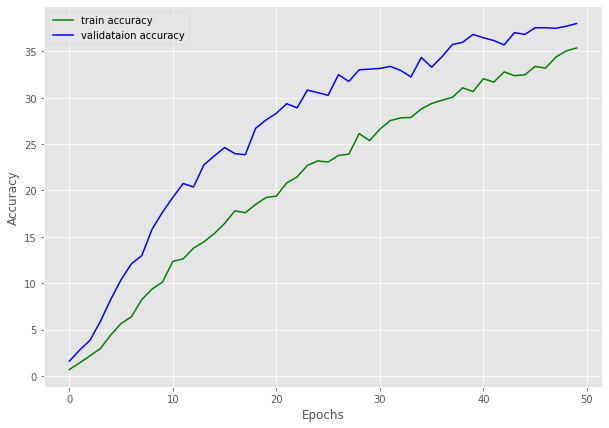

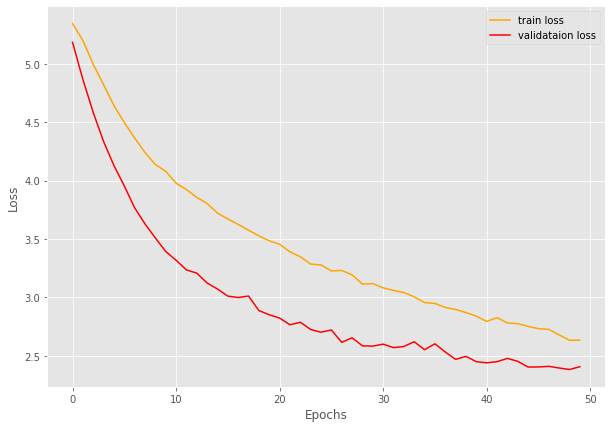

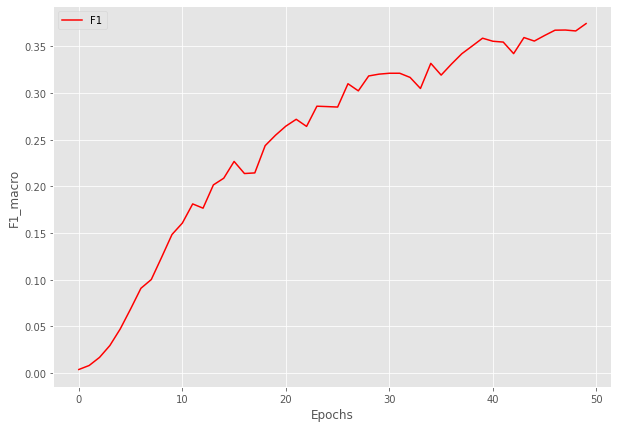

In [34]:
 train_acc, valid_acc, train_loss, valid_loss, f1_sp, model = Train(epochs=epochs, model=model, train_loader=train_loader,
                                                             optimizer=optimizer, valid_loader=valid_loader,
                                                             dataset_classes=dataset_classes, criterion=criterion,
                                                             dir='/notebooks/outputs_Adam_full_dataset')

In [25]:
import torchvision
model2 = torchvision.models.vgg16(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model2.classifier[-1].in_features
model2.classifier[-1] = Linear(num_ftrs, 196)
model2.classifier[-4] = Linear(4096, 4096)
model2.classifier[-7] = Linear(25088, 4096)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [26]:
# Required constants.
TRAIN_DIR = '/notebooks/cars_train/cars_train'
VALID_DIR = '/notebooks/cars_test/cars_test/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 64
NUM_WORKERS = 2

dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
        # Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)
        # Learning_parameters. 
lr = 0.00025
final_lr = 0.01
gamma = 0.00001
epochs = 50
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

total_params = sum(p.numel() for p in model2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = AdaBound(model2.parameters(), lr=lr, final_lr=final_lr, gamma=gamma)
# Loss function.
criterion = CrossEntropyLoss()


model2 = model2.to(device)

[INFO]: Number of training images: 8144
[INFO]: Number of validation images: 8041
Computation device: cuda
Learning rate: 0.00025
Epochs to train for: 50

135,063,556 total parameters.
120,348,868 training parameters.


In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

/tmp/ipykernel_32/3245925117.py:92: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Training loss: 5.370, training acc: 0.823
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 5.091, validation acc: 1.952
f1 for epoch: 0.004986693119182213
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 5.100, training acc: 1.486
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.689, validation acc: 3.569
f1 for epoch: 0.010056505982786504
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.910, training acc: 2.014
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.421, validation acc: 4.378
f1 for epoch: 0.019009382306020155
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.761, training acc: 3.180
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.257, validation acc: 5.472
f1 for epoch: 0.026671891029382694
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.627, training acc: 4.064
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.053, validation acc: 8.195
f1 for epoch: 0.054181379347461076
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.402, training acc: 5.980
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.804, validation acc: 11.305
f1 for epoch: 0.07931259638742656
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.331, training acc: 6.987
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.642, validation acc: 13.755
f1 for epoch: 0.10500209879147765
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.307, training acc: 6.864
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.574, validation acc: 14.849
f1 for epoch: 0.11709410507184775
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.239, training acc: 8.350
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.557, validation acc: 14.364
f1 for epoch: 0.11734006186363734
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.175, training acc: 9.295
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.490, validation acc: 14.899
f1 for epoch: 0.11600726069648189
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.135, training acc: 9.639
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.404, validation acc: 17.324
f1 for epoch: 0.14126338807335587
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.062, training acc: 10.523
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.308, validation acc: 18.480
f1 for epoch: 0.15307763957564455
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.042, training acc: 10.670
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.322, validation acc: 18.605
f1 for epoch: 0.15668160815636628
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.002, training acc: 11.419
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.323, validation acc: 17.784
f1 for epoch: 0.1463568689957883
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.946, training acc: 12.132
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.214, validation acc: 20.930
f1 for epoch: 0.17907658463545992
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.920, training acc: 12.291
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.197, validation acc: 20.868
f1 for epoch: 0.1822403050021221
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.903, training acc: 12.807
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.133, validation acc: 22.211
f1 for epoch: 0.20067571408623705
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.917, training acc: 12.475
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.104, validation acc: 23.467
f1 for epoch: 0.20977535690582252
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.856, training acc: 13.077
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.123, validation acc: 22.845
f1 for epoch: 0.2042878349591655
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.810, training acc: 14.145
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.131, validation acc: 23.542
f1 for epoch: 0.2115629093785884
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.766, training acc: 15.140
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.074, validation acc: 23.492
f1 for epoch: 0.2112709589364764
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.784, training acc: 14.772
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.080, validation acc: 24.027
f1 for epoch: 0.22207702253866216
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.761, training acc: 15.066
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.067, validation acc: 24.338
f1 for epoch: 0.22063140815691343
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.703, training acc: 16.466
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.974, validation acc: 24.698
f1 for epoch: 0.22423775971847276
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.718, training acc: 15.557
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.970, validation acc: 26.775
f1 for epoch: 0.2465271871496087
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.691, training acc: 16.122
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.980, validation acc: 25.867
f1 for epoch: 0.23392989078669107
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.638, training acc: 17.031
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.962, validation acc: 25.992
f1 for epoch: 0.23889531396686234
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.669, training acc: 16.294
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.002, validation acc: 24.972
f1 for epoch: 0.2270284436865754
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.622, training acc: 17.399
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.927, validation acc: 26.875
f1 for epoch: 0.2517187468749689
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.612, training acc: 16.675
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.926, validation acc: 26.962
f1 for epoch: 0.2489176840416004
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.607, training acc: 17.375
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.877, validation acc: 27.372
f1 for epoch: 0.25310415114385704
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.570, training acc: 17.338
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.876, validation acc: 27.410
f1 for epoch: 0.2568287440761393
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.575, training acc: 18.664
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.886, validation acc: 27.783
f1 for epoch: 0.2640514178314819
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.560, training acc: 17.301
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.878, validation acc: 28.666
f1 for epoch: 0.2684406671081528
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.545, training acc: 18.369
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.873, validation acc: 27.932
f1 for epoch: 0.2617676470588044
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.517, training acc: 18.873
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.842, validation acc: 28.218
f1 for epoch: 0.26148391983681674
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.531, training acc: 18.222
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.812, validation acc: 29.126
f1 for epoch: 0.2750712411382165
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.496, training acc: 19.241
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Training loss: 3.482, training acc: 19.266
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.852, validation acc: 29.810
f1 for epoch: 0.2835761363608934
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.473, training acc: 20.297
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.823, validation acc: 29.636
f1 for epoch: 0.27793982948110163
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.474, training acc: 20.125
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.816, validation acc: 29.723
f1 for epoch: 0.28372740191827045
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.446, training acc: 19.953
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.826, validation acc: 28.852
f1 for epoch: 0.26942649092370613
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.452, training acc: 20.555
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation loss: 2.808, validation acc: 29.872
f1 for epoch: 0.28092920763909485
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.428, training acc: 20.187
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.786, validation acc: 29.710
f1 for epoch: 0.2815580043222539
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.402, training acc: 20.923
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.795, validation acc: 29.673
f1 for epoch: 0.27973406222383795
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.373, training acc: 21.230
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.792, validation acc: 29.772
f1 for epoch: 0.2851223424283141
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.391, training acc: 21.120
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.761, validation acc: 31.016
f1 for epoch: 0.2945183893113624
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.384, training acc: 21.022
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.778, validation acc: 30.419
f1 for epoch: 0.2886051257810514
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.355, training acc: 21.574
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.785, validation acc: 29.598
f1 for epoch: 0.28303773937470383
--------------------------------------------------
TRAINING COMPLETE


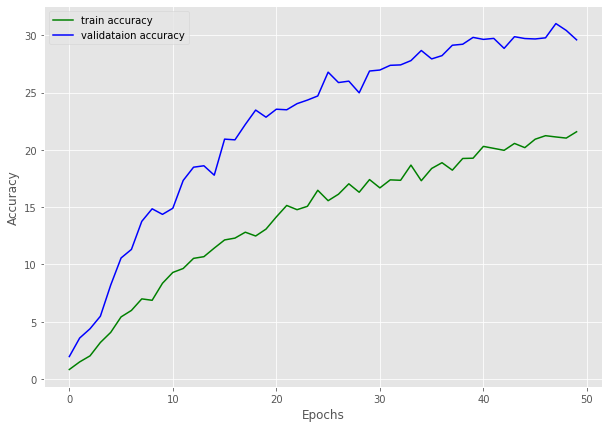

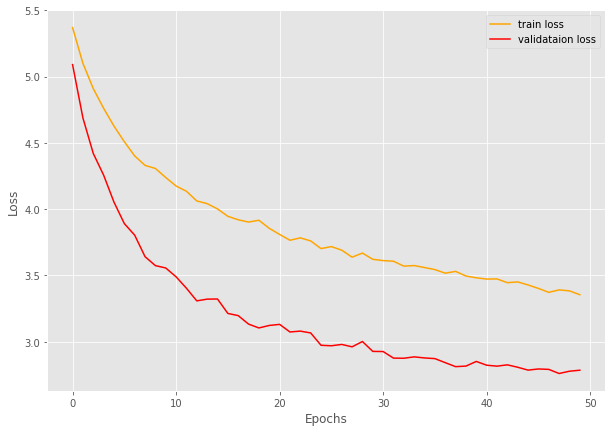

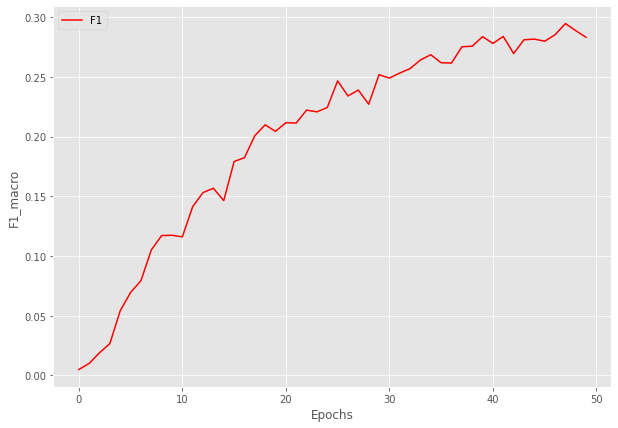

In [28]:
 train_acc2, valid_acc2, train_loss2, valid_loss2, f1_sp2, model2 = Train(epochs=epochs, model=model2, train_loader=train_loader,
                                                                    optimizer=optimizer, valid_loader=valid_loader,
                                                                    dataset_classes=dataset_classes, criterion=criterion, 
                                                                    dir='/notebooks/outputs_Adabound_full_dataset')

In [23]:
import torchvision
model3 = torchvision.models.vgg16(pretrained=True)
for param in model3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model3.classifier[-1].in_features
model3.classifier[-1] = Linear(num_ftrs, 196)
model3.classifier[-4] = Linear(4096, 4096)
model3.classifier[-7] = Linear(25088, 4096)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [24]:
# Required constants.
TRAIN_DIR = '/notebooks/cars_train/cars_train'
VALID_DIR = '/notebooks/cars_test/cars_test/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 64
NUM_WORKERS = 2

dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
        # Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)
        # Learning_parameters. 
lr = 0.0001
final_lr = 0.01
gamma = 0.0001
epochs = 50
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

total_params = sum(p.numel() for p in model3.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = AdaBound(model3.parameters(), lr=lr, final_lr=final_lr, gamma=gamma)
# Loss function.
criterion = CrossEntropyLoss()


model3 = model3.to(device)

[INFO]: Number of training images: 8144
[INFO]: Number of validation images: 8041
Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 50

135,063,556 total parameters.
120,348,868 training parameters.


In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

/tmp/ipykernel_32/3245925117.py:92: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Training loss: 5.347, training acc: 0.651
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 5.184, validation acc: 1.181
f1 for epoch: 0.0012193120960547312
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 5.197, training acc: 1.265
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.849, validation acc: 2.823
f1 for epoch: 0.009837699884905151
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.978, training acc: 1.977
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.562, validation acc: 4.191
f1 for epoch: 0.016393789745682275
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.792, training acc: 3.426
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.282, validation acc: 6.044
f1 for epoch: 0.03537336494443381
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.622, training acc: 4.617
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 4.024, validation acc: 9.924
f1 for epoch: 0.06819907256910164
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.471, training acc: 5.747
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.864, validation acc: 10.981
f1 for epoch: 0.07886594247221781
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.347, training acc: 6.680
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.757, validation acc: 11.553
f1 for epoch: 0.07955484468697654
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.235, training acc: 8.288
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.593, validation acc: 14.849
f1 for epoch: 0.11372536573757075
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.129, training acc: 9.492
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.518, validation acc: 15.259
f1 for epoch: 0.11778165819963626
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 4.037, training acc: 10.584
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.390, validation acc: 18.095
f1 for epoch: 0.14437580758140584
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.980, training acc: 11.346
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.299, validation acc: 18.990
f1 for epoch: 0.15731548292606745
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.914, training acc: 12.561
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.244, validation acc: 19.985
f1 for epoch: 0.16782047012581114
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.835, training acc: 14.059
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.167, validation acc: 21.017
f1 for epoch: 0.17886347883984857
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.801, training acc: 14.612
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.100, validation acc: 23.107
f1 for epoch: 0.203671925413542
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.723, training acc: 14.722
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 3.015, validation acc: 24.835
f1 for epoch: 0.22520221780166794
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.673, training acc: 16.503
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.985, validation acc: 25.320
f1 for epoch: 0.23327603454149348
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.614, training acc: 17.264
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.954, validation acc: 25.457
f1 for epoch: 0.23101677467157417
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.593, training acc: 17.301
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.890, validation acc: 27.074
f1 for epoch: 0.2492891382217668
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.517, training acc: 18.627
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.876, validation acc: 27.621
f1 for epoch: 0.2500442543655593
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.493, training acc: 19.180
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.832, validation acc: 27.857
f1 for epoch: 0.2599516717974519
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.458, training acc: 19.487
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.832, validation acc: 28.181
f1 for epoch: 0.2593859112024472
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.434, training acc: 20.469
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.769, validation acc: 28.889
f1 for epoch: 0.27148950712440156
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.375, training acc: 21.292
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.712, validation acc: 30.307
f1 for epoch: 0.2823983437030918
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.355, training acc: 21.292
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.716, validation acc: 30.320
f1 for epoch: 0.2828285561072039
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.311, training acc: 22.016
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.709, validation acc: 30.021
f1 for epoch: 0.2779879471024077
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.270, training acc: 22.839
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.643, validation acc: 31.675
f1 for epoch: 0.30054533771948927
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.240, training acc: 23.207
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.680, validation acc: 30.693
f1 for epoch: 0.2885546746643885
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.210, training acc: 23.551
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.638, validation acc: 31.911
f1 for epoch: 0.30590361944056216
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.193, training acc: 24.239
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.601, validation acc: 32.396
f1 for epoch: 0.30911947565757014
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.145, training acc: 25.246
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.581, validation acc: 33.827
f1 for epoch: 0.32091673901240786
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.109, training acc: 26.559
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.555, validation acc: 33.690
f1 for epoch: 0.3200855886092806
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.089, training acc: 26.277
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.524, validation acc: 33.914
f1 for epoch: 0.32422637854910175
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.121, training acc: 25.995
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.518, validation acc: 34.660
f1 for epoch: 0.32685566856155956
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.036, training acc: 27.358
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.508, validation acc: 34.585
f1 for epoch: 0.3263109187061143
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 3.011, training acc: 28.659
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.492, validation acc: 34.859
f1 for epoch: 0.3323674065635584
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.995, training acc: 28.475
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.494, validation acc: 35.058
f1 for epoch: 0.33370779535017425
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.974, training acc: 28.794
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.488, validation acc: 34.324
f1 for epoch: 0.3276522355465798
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.967, training acc: 28.905
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.431, validation acc: 36.488
f1 for epoch: 0.35442796265951915
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.933, training acc: 28.856
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.466, validation acc: 34.896
f1 for epoch: 0.3377895318336679
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.884, training acc: 29.973
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.457, validation acc: 35.953
f1 for epoch: 0.3462666262703399
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.873, training acc: 30.403
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.437, validation acc: 36.239
f1 for epoch: 0.3466857932992071
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.859, training acc: 30.685
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.426, validation acc: 36.239
f1 for epoch: 0.35218045324729447
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.837, training acc: 31.496
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.417, validation acc: 36.289
f1 for epoch: 0.3536385080219744
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.843, training acc: 30.869
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.376, validation acc: 37.881
f1 for epoch: 0.3635471016355686
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.798, training acc: 31.778
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.398, validation acc: 37.209
f1 for epoch: 0.3611960246493714
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.773, training acc: 32.011
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.350, validation acc: 38.229
f1 for epoch: 0.37342194608944135
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.761, training acc: 32.834
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.350, validation acc: 38.453
f1 for epoch: 0.37042521718737853
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.740, training acc: 32.625
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.333, validation acc: 39.286
f1 for epoch: 0.38205580990161725
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.759, training acc: 32.429
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.348, validation acc: 38.142
f1 for epoch: 0.37198306893209737
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Training loss: 2.706, training acc: 33.399
Validation


  0%|          | 0/126 [00:00<?, ?it/s]

Validation loss: 2.332, validation acc: 38.664
f1 for epoch: 0.3755044415622684
--------------------------------------------------
TRAINING COMPLETE


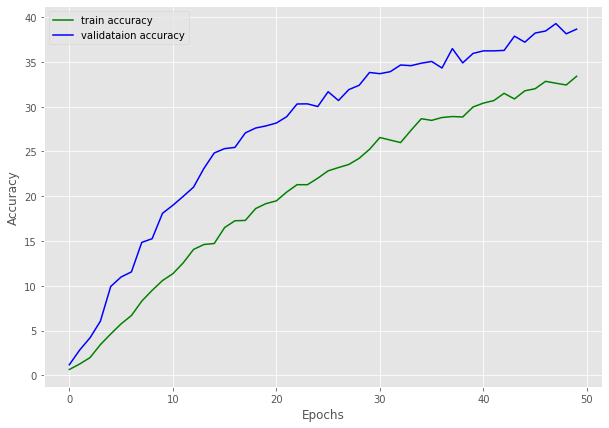

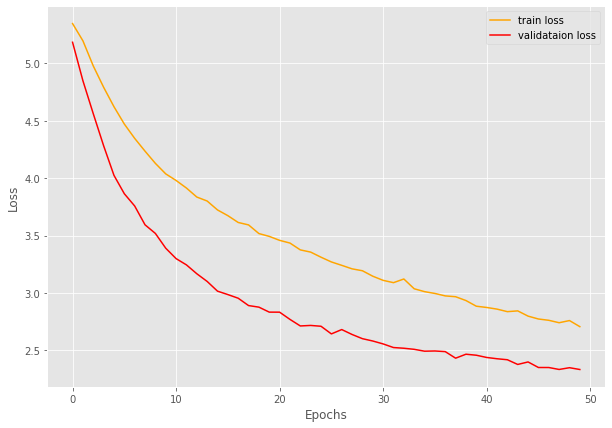

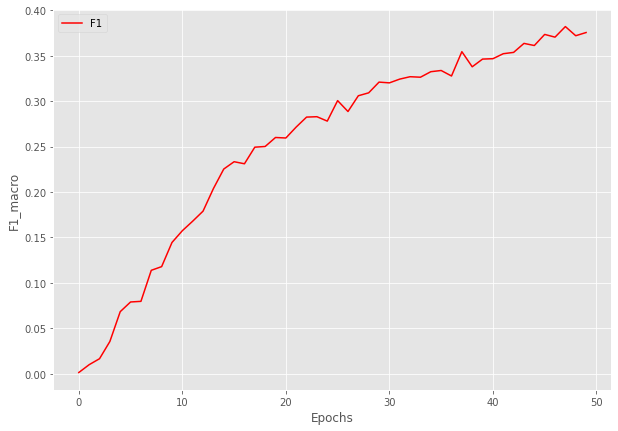

In [26]:
train_acc3, valid_acc3, train_loss3, valid_loss3, f1_sp3, model3 = Train(epochs=epochs, model=model3, train_loader=train_loader,
                                                                    optimizer=optimizer, valid_loader=valid_loader,
                                                                    dataset_classes=dataset_classes, criterion=criterion, 
                                                                    dir='/notebooks/outputs_Adabound_custom_full_dataset')